In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [192]:
df = pd.read_csv('EnergyConsumption.csv', parse_dates = ['Datetime'] )

In [193]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478
1,2004-12-31 02:00:00,12865
2,2004-12-31 03:00:00,12577
3,2004-12-31 04:00:00,12517
4,2004-12-31 05:00:00,12670


In [194]:
# format columns name
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [195]:
df=format_column_names(df)

In [196]:
# Convert 'date' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract year and month separately
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

# Combine year and month to create a new column
df['year_month'] = df['month'].astype(str) + '-01-' + df['year'].astype(str)
df['year_month'] = pd.to_datetime(df['year_month'])

# Group by year-month and sum the profits
df = df.groupby('year_month')['aep_mw'].sum().reset_index()

In [197]:
df.dtypes

year_month    datetime64[ns]
aep_mw                 int64
dtype: object

In [207]:
df.set_index('year_month', inplace = True)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2004-10-01 to 2018-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   aep_mw  167 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [209]:
df.head()

,aep_mw
year_month,
2004-10-01,10349073
2004-11-01,10677917
2004-12-01,12452864
2005-01-01,12735114
2005-02-01,11085745


# Decomposition

In [210]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposition(data, model):
    result = seasonal_decompose(data, model=model)

    # Assign decomposed components to variables
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Plotting the components
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 20))

    plt.subplot(411)
    plt.plot(data, label='Original', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

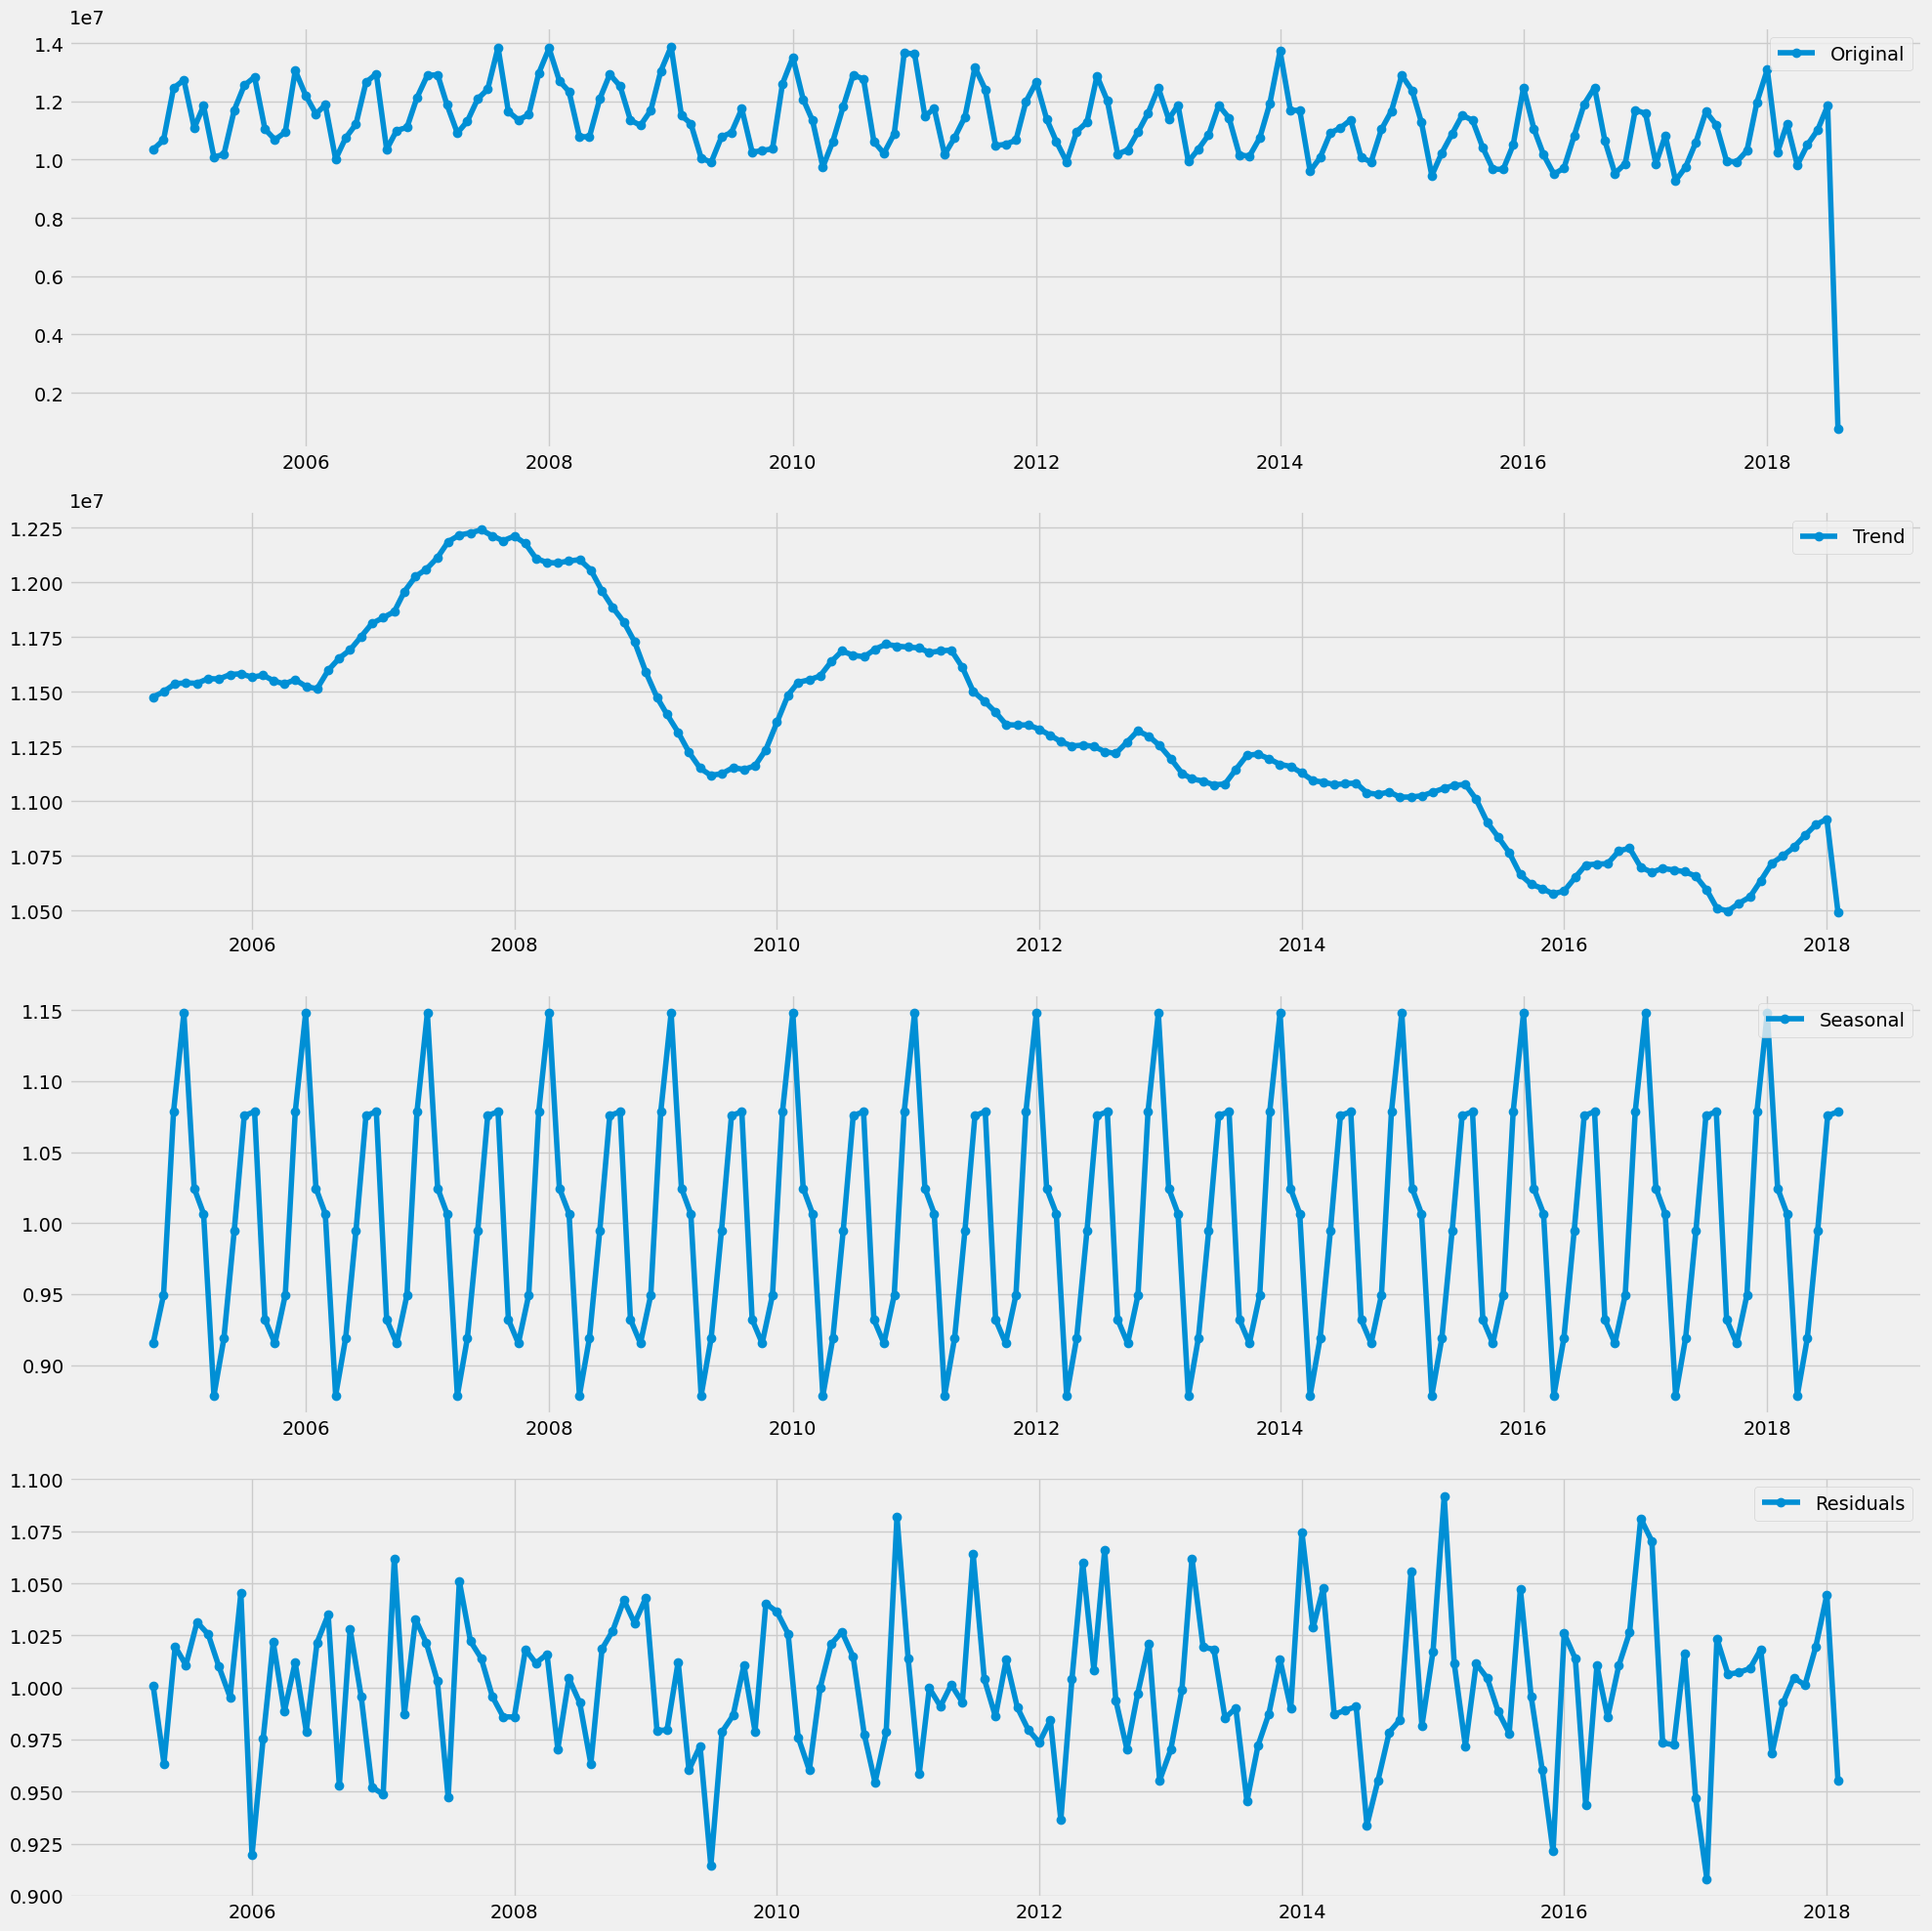

In [211]:
decomposition(df['aep_mw'], 'multiplicative')

# Check Seasonality

In [216]:
def check_seasonality(data):
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(data)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()
    
    # Check for seasonality based on the seasonal component
    seasonal_component = decomposition.seasonal
    seasonal_std = seasonal_component.std()
    
    # Define a threshold for detecting seasonality
    threshold = 0.05
    
    if seasonal_std > threshold:
        print("Seasonality detected in the data.")
    else:
        print("No clear seasonality detected in the data.")

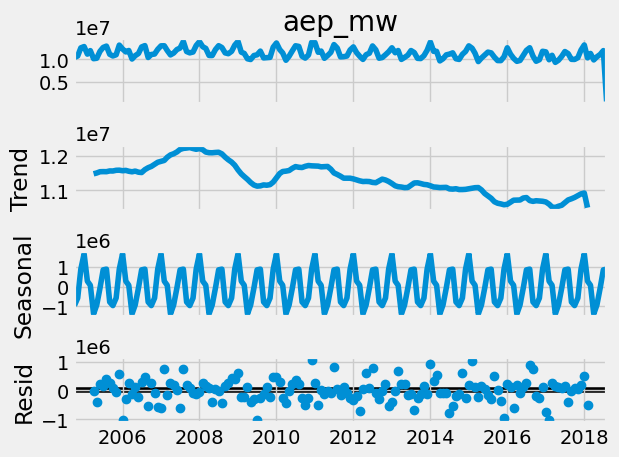

Seasonality detected in the data.


In [218]:
check_seasonality(df['aep_mw'])

# Model

In [136]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import  ExponentialSmoothing

In [119]:

# Splitting data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Set index frequency
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
train.index.freq = train.index.inferred_freq
test.index.freq = test.index.inferred_freq

pred = test.copy()

## Simple Exponential Smoothing

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


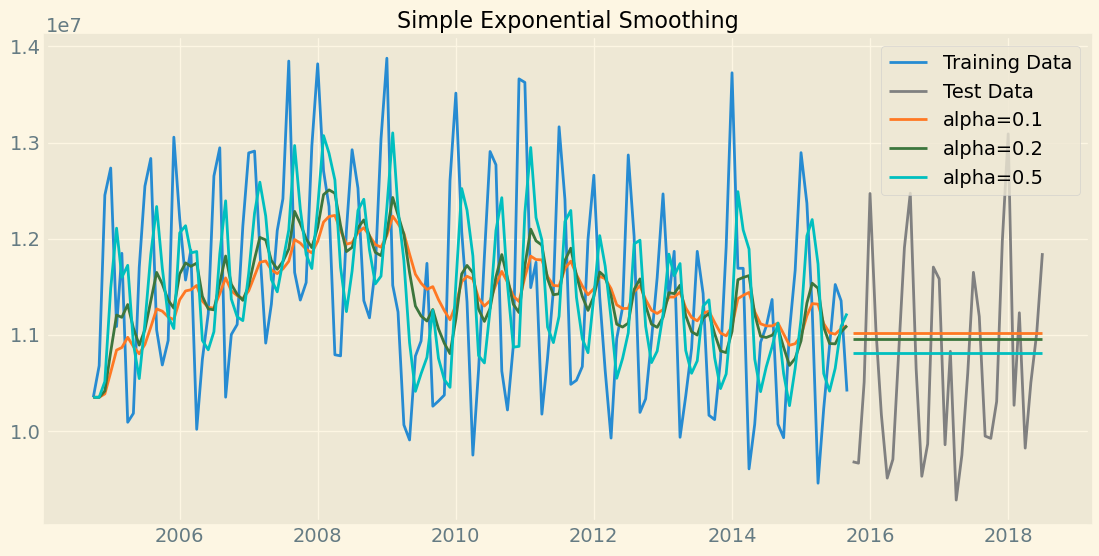

In [132]:
model = SimpleExpSmoothing(np.asarray(train['aep_mw']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(len(test))

fit2 = model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(len(test))

fit3 = model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(len(test))

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['aep_mw'], label='Training Data')
ax.plot(test.index, test['aep_mw'], color="gray", label='Test Data')

for p, f, c, alpha in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823', '#3c763d', 'c'), (fit1.params['smoothing_level'], fit2.params['smoothing_level'], fit3.params['smoothing_level'])):
    ax.plot(train.index, f.fittedvalues, color=c, label=f'alpha={alpha:.1f}')
    ax.plot(test.index, p, color=c)

plt.title("Simple Exponential Smoothing")
plt.legend()
plt.show()

## Holt Trend Exponential Smoothing

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


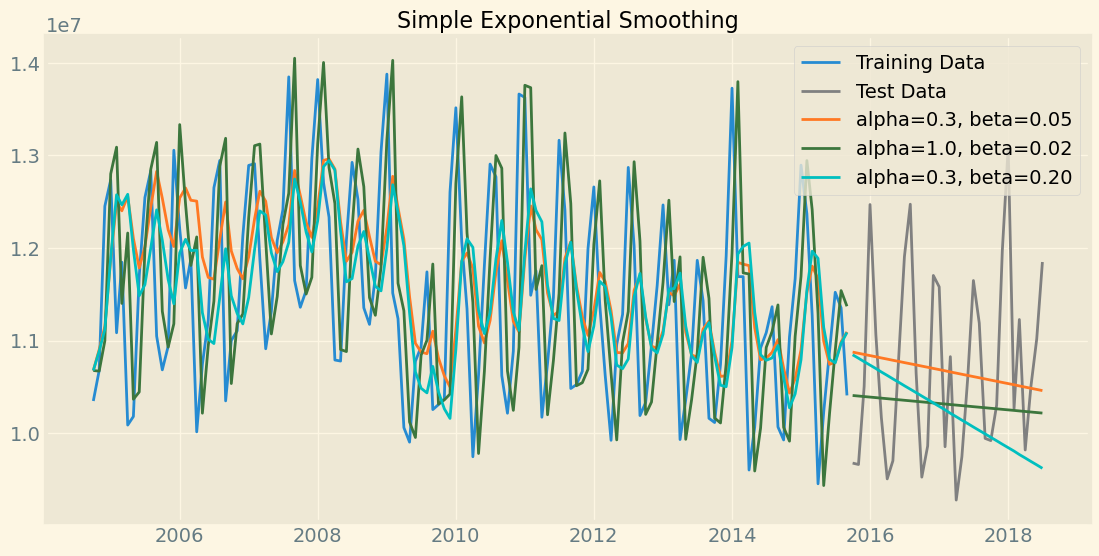

In [134]:
model = Holt(np.asarray(train['aep_mw']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05)
pred1 = fit1.forecast(len(test))
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test))
fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2)
pred3 = fit3.forecast(len(test))


# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['aep_mw'], label='Training Data')
ax.plot(test.index, test['aep_mw'], color="gray", label='Test Data')

for p, f, c, alpha, beta in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823', '#3c763d', 'c'), (fit1.params['smoothing_level'], fit2.params['smoothing_level'], fit3.params['smoothing_level']), (fit1.params['smoothing_trend'], fit2.params['smoothing_trend'], fit3.params['smoothing_trend'])):
    ax.plot(train.index, f.fittedvalues, color=c, label=f'alpha={alpha:.1f}, beta={beta:.2f}')
    ax.plot(test.index, p, color=c)

plt.title("Simple Exponential Smoothing")
plt.legend()
plt.show()

## Seasonal Exponential Smoothing

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


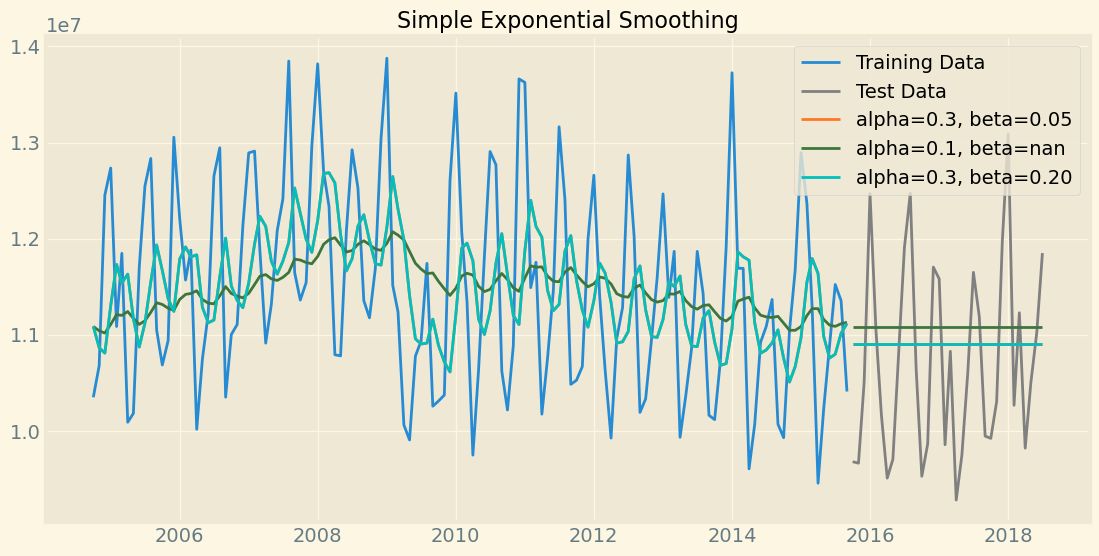

In [170]:

# Assuming your DataFrame is named 'train' and 'test'

# Fit Seasonal Exponential Smoothing models without trend
model = ExponentialSmoothing(train['aep_mw'])
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05)
pred1 = fit1.forecast(len(test))
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test))
fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2)
pred3 = fit3.forecast(len(test))


# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['aep_mw'], label='Training Data')
ax.plot(test.index, test['aep_mw'], color="gray", label='Test Data')

for p, f, c, alpha, beta in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823', '#3c763d', 'c'), (fit1.params['smoothing_level'], fit2.params['smoothing_level'], fit3.params['smoothing_level']), (fit1.params['smoothing_trend'], fit2.params['smoothing_trend'], fit3.params['smoothing_trend'])):
    ax.plot(train.index, f.fittedvalues, color=c, label=f'alpha={alpha:.1f}, beta={beta:.2f}')
    ax.plot(test.index, p, color=c)

plt.title("Simple Exponential Smoothing")
plt.legend()
plt.show()

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


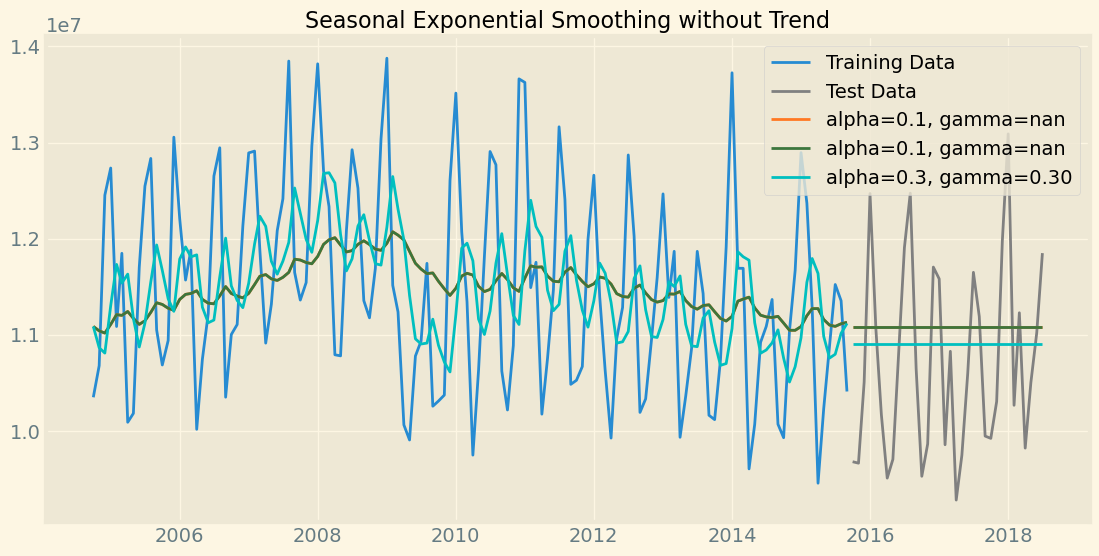

In [166]:


# Fit models
fit2 = model.fit()
pred2 = fit2.forecast(len(test))

fit3 = model.fit(optimized=True)
pred3 = fit3.forecast(len(test))

fit4 = model.fit(smoothing_level=0.3, smoothing_seasonal=0.3)
pred4 = fit4.forecast(len(test))

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['aep_mw'], label='Training Data')
ax.plot(test.index, test['aep_mw'], color="gray", label='Test Data')

# Plot fitted values and predictions
for f, p, c, alpha, gamma in zip((fit2, fit3, fit4), (pred2, pred3, pred4), ('#ff7823', '#3c763d', 'c'), (fit2.params['smoothing_level'], fit3.params['smoothing_level'], fit4.params['smoothing_level']), (fit2.params['smoothing_seasonal'], fit3.params['smoothing_seasonal'], fit4.params['smoothing_seasonal'])):
    ax.plot(train.index, f.fittedvalues, color=c, label=f'alpha={alpha:.1f}, gamma={gamma:.2f}')
    ax.plot(test.index, p, color=c)

plt.title("Seasonal Exponential Smoothing without Trend")
plt.legend()
plt.show()

## Seasonal Trend Exponential Smoothing

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


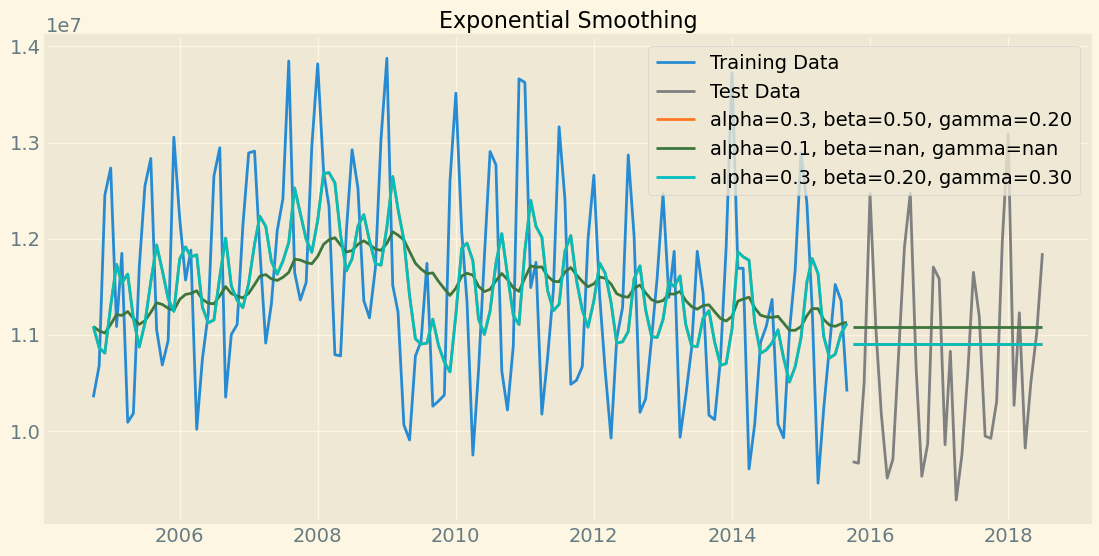

In [160]:
# Fit Exponential Smoothing models
model = ExponentialSmoothing(np.asarray(train['aep_mw']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=0.3, smoothing_trend=0.5, smoothing_seasonal=0.2)
pred1 = fit1.forecast(len(test))

fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test))

fit3 = model.fit(smoothing_level=0.3, smoothing_trend=0.2, smoothing_seasonal=0.3)
pred3 = fit3.forecast(len(test))

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['aep_mw'], label='Training Data')
ax.plot(test.index, test['aep_mw'], color="gray", label='Test Data')

for p, f, c, alpha, beta, gamma in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823', '#3c763d', 'c'), (fit1.params['smoothing_level'], fit2.params['smoothing_level'], fit3.params['smoothing_level']), (fit1.params['smoothing_trend'], fit2.params['smoothing_trend'], fit3.params['smoothing_trend']), (fit1.params['smoothing_seasonal'], fit2.params['smoothing_seasonal'], fit3.params['smoothing_seasonal'])):
    ax.plot(train.index, f.fittedvalues, color=c, label=f'alpha={alpha:.1f}, beta={beta:.2f}, gamma={gamma:.2f}')
    ax.plot(test.index, p, color=c)

plt.title("Exponential Smoothing")
plt.legend()
plt.show()